# Implementing Shor's algorithm in Perceval

This notebook presents a simulation in Perceval of a 4-qubit 12-modes optical circuit performing Shor's algorithm, based on Alberto Politi, Jonathan C.F. Matthews, and Jeremy L. O'brien. "Shor’s quantum factoring algorithm on a photonic chip." Science 325.5945 (2009): 1221-1221. https://www.science.org/doi/10.1126/science.1173731

## Shor's algorithm

The purpose of Shor's algorithm is to find nontrivial factors of a given number $N$ in polynomial time, yielding an near-exponential speedup compared to state of the art classical algortihms.

The main routine of Shor's algorithm consists in finding the order $r$ of a number $a \in \mathbb{Z}_N$, i.e. the smallest integer $r$ such that $a^r = 1 \pmod N$.

If the order of a randoly chosen $a$ which is coprime with $N$ is even, then $(a^{r/2} - 1)(a^{r/2} + 1) = k N$. If none of these factors are multiples of $N$, then $\gcd(N, a^{r/2} - 1)$ and $\gcd(N, a^{r/2} + 1)$ are nontrivial factors of $N$.

## Preliminaries

In [1]:
import sys
print("Python version:", sys.version)

Python version: 3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC v.1929 64 bit (AMD64)]


In [2]:
from IPython import display
from collections import Counter
from tabulate import tabulate
from tqdm.auto import tqdm

import sympy as sp
import numpy as np
from scipy.optimize import minimize

import perceval as pcvl
import quandelibc as qc
import perceval.lib.phys as phys
import perceval.lib.symb as symb

print("Perceval version:", pcvl.__version__)

Perceval version: 0.4.2.post6+2022.5.24


### Path encoding functions

The following functions allow for conversion between the qubit and Fock state representations.

In [3]:
def toFockState(qubitState):
    # path encoding
    pe = {0:[1,0],  1:[0,1]}
    return [0] + pe[qubitState[0]] + pe[qubitState[2]] + [0, 0] + pe[qubitState[1]] + pe[qubitState[3]] + [0]

In [4]:
def toQubitState(fockState):
    # qubit modes
    x1 = [1, 2]
    f1 = [3, 4]
    x2 = [7, 8]
    f2 = [9, 10]
    # auxiliary modes
    am1 = [0, 5]
    am2 = [6, 11]
    
    # auxiliary modes
    for i in am1 + am2:
        if fockState[i]!=0:
            return None
    L=[]
    # qubit modes
    for q in [x1, x2, f1, f2]:
        if fockState[q[0]]+fockState[q[1]] != 1:
            return None
        else:
            L.append(fockState[q[1]])
    return L

In [5]:
def strState(state):
    return str(pcvl.BasicState(state))

## The circuit

### Quantum circuit

The quantum circuit has been optimized after choosing parameters $N = 15$ and $a = 2$, and aims to calculate $r=4$.
It features 5 qubits labelled $x_0, x_1, x_2$ and $f_1, f_2$. Qubits $x_i$ and $f_1$ are initially in state $|0\rangle$, and $f_2$ in state $|1\rangle$.
In the non-optimised Shor algorithm, qubits $x_i$ encode a binary number representing a pre-image of the Modular Exponentiation Function (MEF) $x \mapsto a^x \pmod N$, while qubits $f_i$ hold the image obtained after applying the MEF to qubits $x_i$. Applying the MEF when qubits $x_i$ hold a superposition of different pre-images (obtained with H gates on qubits $x_i$) allows to efficiently compute the order $r$ of parameter $a$ modulo $N$.

The circuit consists of $\mathsf{H}$ gates being first applied to each $x_i$ qubit, followed by $\mathsf{CNOT}$ gates applied on $x_1, f_1$ and $x_2, f_2$ pairs, where $x_i$ are control qubits; finally the inverse $\mathsf{QFT}$ algorithm is applied on qubits $x_i$.

$\mathsf{CNOT}$ gates on $x_i, f_i$ pairs ($x_i$ being the control) are implemented using $\mathsf{H}$ and $\mathsf{CZ}$ gates: the $\mathsf{CZ}$ gate is sandwiched between two applications of $\mathsf{H}$ on $f_i$.

The input state of the circuit after optimisation is $|0\rangle_{x_0}|0\rangle_{x_1}|0\rangle_{x_2}|0\rangle_{f_1}|1\rangle_{f_2}$.

The expected output state is then $\frac{1}{2} |0\rangle_{x_0} \otimes \left ( |0\rangle_{x_1}|0\rangle_{f_1} + |1\rangle_{x_1}|1\rangle_{f_1} \right ) \otimes \left ( |0\rangle_{x_2}|1\rangle_{f_2} + |1\rangle_{x_2}|0\rangle_{f_2} \right )$.

### Photonic circuit

The optical circuit from the result by Politi et al features twelve modes (ordered from 0 to 11 from top to bottom).

During the execution, qubit $x_0$ remains unentangled from the other qubits. It can therefore be removed from the optical implementation.

The qubits $x_1, x_2, f_1, f_2$ are path encoded as modes $(1, 2)$, $(3, 4)$, $(7, 8)$, $(9, 10)$ respectively. The four remaining modes are used as auxiliary modes to implement the $\mathsf{CZ}$ gates.

With path encoding each $\mathsf{H}$ gate in the quantum circuit is implemented with a beam splitter with reflectivity $R=1/2$ between the two pathes corresponding to the qubit. In our implementation in Perceval, phase shifters are added to properly tune the phase between each path.

$\mathsf{CZ}$ gates are implemented with three beam splitters with reflectivity $R=2/3$ acting on six modes: one inner BS creates interference between the two qubits, and two outer BS balance detection probability using auxiliary modes.
This optical implementation succesfully yields the output state produced by a $\mathsf{CZ}$ gate with probability 1/9; otherwise it creates a dummy state, which can be removed by post-selection.

In the case $r=4$ the QFT can be performed classically and doesn't need to be implemented in the photonic circuit.

## In perceval

### Implementing the circuit

In [6]:
circ = pcvl.Circuit(12)

# qubit modes
# for qubit states 0, 1
x1 = [1, 2]
f1 = [3, 4]
x2 = [7, 8]
f2 = [9, 10]
# auxiliary modes
am1 = [0, 5]
am2 = [6, 11]


# H gates
for q in [x1, f1, x2, f2]:
    circ.add(q, symb.BS(R=1/2, phi=sp.pi/2))
    circ.add(q[1], symb.PS(phi=sp.pi))

# CZ gates
for x, f, am in [(x1, f1, am1), (x2, f2, am2)]:
    circ.add((am[0], x[0]), symb.BS(R=1/3)) # T = 1/3
    circ.add((x[1],  f[0]), symb.BS(R=1/3))
    circ.add((f[1], am[1]), symb.BS(R=1/3))

# H gates
for q in [f1, f2]:
    circ.add(q, symb.BS(R=1/2, phi=sp.pi/2))
    circ.add(q[1], symb.PS(phi=sp.pi))

Optical circuit for Shor's algorithm


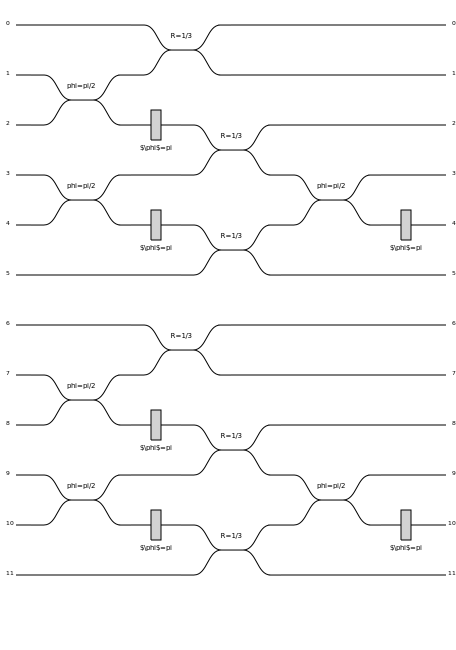

In [7]:
print("Optical circuit for Shor's algorithm")
pcvl.pdisplay(circ)

In [8]:
print("The associated matrix")
pcvl.pdisplay(circ.U)

The associated matrix


### Input state

In the preliminaries we provided functions to map qubit states to the corresponding Fock states and vice-versa.

A *computational basis qubit state* on qubits $x_1, f_1, x_2, f_2$ is represented with a list of 4 boolean values.

A *Fock state* is represented with a list of twelve integer values.
As described above, for Fock states, the modes are enumerated as follows:
* mode pairs $(1,2), (3,4), (7,8), (9,10)$ respectively correspond to states $0,1$ for qubits $x_1, f_1, x_2, f_2$
* modes $0,5,6,11$ are auxiliary modes used for CZ gates

The input state of the circuit is $|0\rangle_{x_1}|0\rangle_{x_2}|0\rangle_{f_1}|1\rangle_{f_2}$.
With path encoding this corresponds to sending 4 photons in total in the optical circuit, in the input modes corresponding to the inital state of each qubit.

In [9]:
qubit_istate = [0,0,0,1]
istate = toFockState(qubit_istate)

print("Input qubit state:", strState(qubit_istate))
print("Corresponding input Fock state:", strState(istate))

Input qubit state: |0,0,0,1>
Corresponding input Fock state: |0,1,0,1,0,0,0,1,0,0,1,0>


## Simulation

In [10]:
backend = pcvl.BackendFactory().get_backend("Naive")
simulator = backend(circ)

### Computing the output state

Using perceval we compute the output state obtained with the optical circuit.

#### Amplitudes

We first decompose the output state in the computational basis and plot the corresponding amplitudes.

In [11]:
output_qubit_states = [
    [x1,x2,f1,f2]
    for x1 in [0,1] for x2 in [0,1] for f1 in [0,1] for f2 in [0,1]
]

print("Output state amplitudes: (post-selected on qubit states, not renormalized)")
print("|x1,x2,f1,f2>")
for oqstate in output_qubit_states:
    ostate = toFockState(oqstate)
    a = simulator.probampli(pcvl.BasicState(pcvl.BasicState(istate)), pcvl.BasicState(ostate))
    print(strState(oqstate), a)

Output state amplitudes: (post-selected on qubit states, not renormalized)
|x1,x2,f1,f2>
|0,0,0,0> (4.336808689942018e-19-1.925929944387236e-34j)
|0,0,0,1> -3.851859888774472e-34j
|0,0,1,0> (4.336808689942018e-19-3.851859888774472e-34j)
|0,0,1,1> 7.703719777548943e-34j
|0,1,0,0> (1.734723475976807e-18+5.204170427930421e-18j)
|0,1,0,1> (1.734723475976807e-18+7.806255641895632e-18j)
|0,1,1,0> (1.734723475976807e-18+8.673617379884035e-19j)
|0,1,1,1> (1.734723475976807e-18+3.469446951953614e-18j)
|1,0,0,0> (2.168404344971009e-18+3.469446951953614e-18j)
|1,0,0,1> (1.734723475976807e-18-3.469446951953614e-18j)
|1,0,1,0> (2.168404344971009e-18+8.673617379884035e-18j)
|1,0,1,1> (1.734723475976807e-18-8.673617379884035e-19j)
|1,1,0,0> (-0.055555555555555594+4.163336342344337e-17j)
|1,1,0,1> (-0.05555555555555559+4.683753385137379e-17j)
|1,1,1,0> (-0.05555555555555559+4.5102810375396984e-17j)
|1,1,1,1> (-0.055555555555555594+5.204170427930421e-17j)


The amplitudes obtained with perceval correspond to the expected output state
$$\frac{1}{2} \left ( |0\rangle_{x_1}|0\rangle_{f_1} + |1\rangle_{x_1}|1\rangle_{f_1} \right ) \otimes \left ( |0\rangle_{x_2}|1\rangle_{f_2} + |1\rangle_{x_2}|0\rangle_{f_2} \right )$$
up to numerical precision, without renormalization.

#### Distribution

We now compute the probabilities to obtain each outcome corresponding to measuring the expected output state in the computational basis.

In [12]:
input_states = {
    pcvl.BasicState(pcvl.BasicState(istate)): strState(qubit_istate)
}

expected_output_states = {
    pcvl.BasicState(toFockState([x1,x2,x1,1-x2])): strState([x1,x2,x1,1-x2])
    for x1 in [0,1] for x2 in [0,1]
}

ca = pcvl.CircuitAnalyser(simulator, input_states, expected_output_states)
ca.compute()

print("Output state distribution: (post-selected on expected qubit states, not renormalized)")
print("|x1,x2,f1,f2>")
pcvl.pdisplay(ca)

Output state distribution: (post-selected on expected qubit states, not renormalized)
|x1,x2,f1,f2>


,"|0,0,0,1>","|0,1,0,0>","|1,0,1,1>","|1,1,1,0>"
"|0,0,0,1>",0,0,0,0.003086


The distribution computed with Perceval is uniform over each outcome, which corresponds to the expected distribution obtained in the paper when $x_0 = 0$.

### Interpretation of the outcomes

For each outcome we consider the values of qubits $x_2, x_1, x_0$ (where $x_0$ is 0) which represent a binary number between 0 and 7, here corresponding to 0, 4, 2 and 6 in the order of the table above.
After sampling the circuit, obtainig outcomes 2 or 6 allows to successfully compute the order $r=4$.
Obtaining outcome 0 is an expected failure of the quantum circuit, inherent to Shor's algorithm.
Outcome 4 is an expected failure as well, as it only allows to compute the trivial factors 1 and 15.

Since the distribution is uniform the circuit successfully yields a successful outcome with probability 1/2. This probability can be amplified exponentially close to $1$ by sampling the circuit multiple times.